In [9]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import scipy
import scipy.io as sio

from matplotlib import patches
from scipy.interpolate import griddata

In [ ]:
def topoplotIndie(Values,chanlocs,title="",ax=0):

    labels = []
    Th     = []
    Rd     = []
    x      = []
    y      = []

    for ci in range(len(chanlocs[0])):
        labels.append(chanlocs[0]["labels"][ci][0])
        Th.append(np.pi/180*chanlocs[0]["theta"][ci][0][0])
        Rd.append(chanlocs[0]["radius"][ci][0][0])
        x.append( Rd[ci]*np.cos(Th[ci]) )
        y.append( Rd[ci]*np.sin(Th[ci]) )

    headrad = .5
    plotrad = .6

    squeezefac = headrad/plotrad
    x = np.array(x)*squeezefac
    y = np.array(y)*squeezefac


    xmin = np.min( [-headrad,np.min(x)] )
    xmax = np.max( [ headrad,np.max(x)] )
    ymin = np.min( [-headrad,np.min(y)] )
    ymax = np.max( [ headrad,np.max(y)] )
    xi   = np.linspace(xmin,xmax,67)
    yi   = np.linspace(ymin,ymax,67)

    Xi, Yi = np.mgrid[xmin:xmax:67j,ymin:ymax:67j]
    Zi = griddata(np.array([y,x]).T,Values,(Yi,Xi))

    mask = np.sqrt(Xi**2 + Yi**2) <= headrad
    Zi[mask == 0] = np.nan


    if ax==0:
        fig  = plt.figure()
        ax   = fig.add_subplot(111, aspect = 1)
    clim = np.max(np.abs(Zi[np.isfinite(Zi)]))*.8
    ax.contourf(yi,xi,Zi,60,cmap=plt.cm.jet,zorder=1, vmin=-clim,vmax=clim)

    circle = patches.Circle(xy=[0,0],radius=headrad,edgecolor="k",facecolor="w",zorder=0)
    ax.add_patch(circle)

    circle = patches.Ellipse(xy=[np.min(xi),0],width=.05,height=.2,angle=0,edgecolor="k",facecolor="w",zorder=-1)
    ax.add_patch(circle)
    circle = patches.Ellipse(xy=[np.max(xi),0],width=.05,height=.2,angle=0,edgecolor="k",facecolor="w",zorder=-1)
    ax.add_patch(circle)

    xy = [[0,np.max(yi)+.06], [-.2,.2],[.2,.2]]
    polygon = patches.Polygon(xy=xy,facecolor="w",edgecolor="k",zorder=-1)
    ax.add_patch(polygon)
    
    ax.scatter(y,x,marker="o", c="k", s=15, zorder = 3)

    ax.set_xlim([-.6,.6])
    ax.set_ylim([-.6,.6])
    ax.axis("off")
    ax.set_title(title)
    ax.set_aspect("equal")

In [ ]:
def filterFGx(data,srate,f,fwhm,showplot=False):

    hz = np.linspace(0,srate,data.shape[1])

    s  = fwhm*(2*np.pi-1)/(4*np.pi) 
    x  = hz-f                      
    fx = np.exp(-.5*(x/s)**2)    
    fx = fx/np.max(fx)              

    filtdat = np.zeros( np.shape(data) )
    for ci in range(filtdat.shape[0]):
        filtdat[ci,:] = 2*np.real( np.fft.ifft( np.fft.fft(data[ci,:])*fx ) )

    empVals = [0,0,0]

    idx = np.argmin(np.abs(hz-f))
    empVals[0] = hz[idx]

    empVals[1] = hz[idx-1+np.argmin(np.abs(fx[idx:]-.5))] - hz[np.argmin(np.abs(fx[:idx]-.5))]

    tmp  = np.abs(scipy.signal.hilbert(np.real(np.fft.fftshift(np.fft.ifft(fx)))))
    tmp  = tmp / np.max(tmp)
    tx   = np.arange(0,data.shape[1])/srate
    idxt = np.argmax(tmp)

    empVals[2] = (tx[idxt-1+np.argmin(np.abs(tmp[idxt:]-.5))] - tx[np.argmin(np.abs(tmp[0:idxt]-.5))])*1000

    if showplot:
        plt.subplot(211)
        plt.plot(hz,fx,"o-")
        xx = [ hz[np.argmin(np.abs(fx[:idx]-.5))], hz[idx-1+np.argmin(np.abs(fx[idx:]-.5))] ]
        yy = [ fx[np.argmin(np.abs(fx[:idx]-.5))], fx[idx-1+np.argmin(np.abs(fx[idx:]-.5))] ]
        plt.plot(xx,yy,"k--")
        plt.xlim([np.max(f-10,0),f+10])

        plt.title("Requested: %g, %g Hz; Empirical: %.2f, %.2f Hz" %(f,fwhm,empVals[0],empVals[1]) )
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Amplitude gain")

        plt.subplot(212)
        tmp1 = np.real(np.fft.fftshift(np.fft.ifft(fx)))
        tmp1 = tmp1 / np.max(tmp1)
        tmp2 = np.abs(scipy.signal.hilbert(tmp1))
        plt.plot(tx-np.mean(tx),tmp1, tx-np.mean(tx),tmp2)
        plt.xlim([-empVals[2]*2/1000,empVals[2]*2/1000])
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude gain")
    plt.show()

    return filtdat,empVals

In [ ]:
matfile = sio.loadmat("../data/CEdata.mat")
EEG = matfile["EEG"][0,0]
EEG["times"] = EEG["times"][0]
EEG["data"] = np.double(EEG["data"]) 

In [13]:
centerFreq = 7
freqFWHM = 5

fdata = copy.deepcopy(EEG["data"])
for ti in range(int(EEG["trials"])):
    tmdat = EEG["data"][:,:,ti]
    fdata[:,:,ti] = filterFGx(tmdat,EEG["srate"][0][0],centerFreq,freqFWHM)[0]

times = [-700,0,700]
tidx0 = np.argmin(np.abs(EEG["times"]-times[0]))
tidx1 = np.argmin(np.abs(EEG["times"]-times[1]))
tidx2 = np.argmin(np.abs(EEG["times"]-times[2]))

C:\Users\kerem\AppData\Local\Temp\ipykernel_6200\3254326576.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for ti in range(int(EEG['trials'])):


In [14]:
covPre = np.zeros( (EEG["nbchan"][0][0],EEG["nbchan"][0][0]) )
covPst = np.zeros( (EEG["nbchan"][0][0],EEG["nbchan"][0][0]) )

for ti in range(EEG["trials"][0][0]):
    
    tpre    = fdata[:,tidx0:tidx1,ti] 
    covPre += np.cov(tpre)
    
    tpst    = fdata[:,tidx1:tidx2,ti] 
    covPst += np.cov(tpst)
    
covPre = covPre/ti
covPst = covPst/ti

evals,evecs = scipy.linalg.eigh(covPst,covPre)
soidx = np.argsort(evals)[::-1]
evals = evals[soidx]
evecs = evecs[:,soidx]

maps   = np.zeros( (4,int(EEG["nbchan"])) )
compts = np.zeros( (4,int(EEG["pnts"]),int(EEG["trials"])) )

C:\Users\kerem\AppData\Local\Temp\ipykernel_6200\1448111895.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  maps   = np.zeros( (4,int(EEG['nbchan'])) )
C:\Users\kerem\AppData\Local\Temp\ipykernel_6200\1448111895.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  compts = np.zeros( (4,int(EEG['pnts']),int(EEG['trials'])) )


<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
C:\Users\kerem\AppData\Local\Temp\ipykernel_6200\2611558942.py:5: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\lambda$')


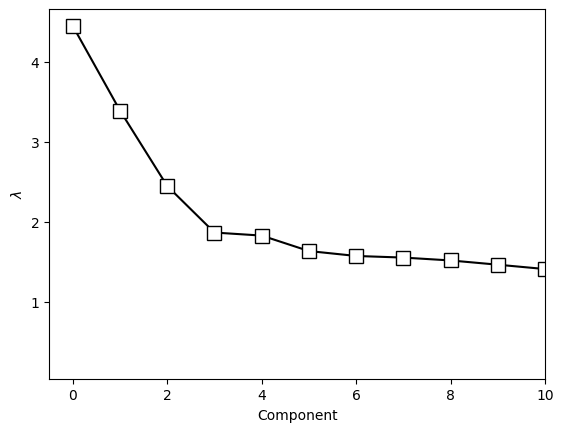

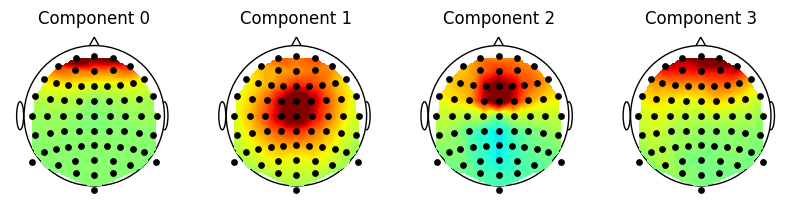

In [15]:
plt.plot(evals,"ks-",markerfacecolor="w",markersize=10)
plt.xlim([-.5,10])
plt.xlabel("Component")
plt.ylabel("$\lambda$")

_,axs = plt.subplots(1,4,figsize=(10,4))

for compi in range(4):
    
    maps[compi,:] = evecs[:,compi].T@covPst
    idx           = np.argmax( np.abs(maps[compi,:]) )
    maps[compi,:] = maps[compi,:] * np.sign(maps[compi,idx])
    topoplotIndie(maps[compi,:],EEG["chanlocs"],f"Component {compi}",axs[compi])
    
    tmpts = evecs[:,compi].T @ np.reshape(EEG["data"],(EEG["nbchan"][0][0],-1),order="F")
    compts[compi,:,:] = np.reshape( tmpts,(EEG["pnts"][0][0],EEG["trials"][0][0]),order="F" )

plt.show()